# Sentimental Analysis
by Anny Liu, Huanrui Chen

This file include the code for sentimental analysis (based on existing bert model) 
and the visualization for emotional change as well as tendency chart.

Help source: <br/>
This is a fine-tuned bert model based on the tensorflow package, 
and we used the Chinese labeled dataset Weibo data as a training library 
to recognize Chinese text. Detailed refernce can be found in reference.md

In [1]:
# -*- coding: utf-8 -*-
import os
import re
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections  
import itertools
# from wordcloud import WordCloud,ImageColorGenerator,random_color_func 
from PIL import Image 
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['FangSong'] # Chinese Font Settings
plt.rcParams['axes.unicode_minus'] = False  # Solve the problem that saving negative sign '-' displayed as a square
import warnings
warnings.filterwarnings("ignore")

In [2]:
#==================read model
from transformers import BertForSequenceClassification,BertTokenizer
from transformers import pipeline
from tqdm import tqdm
import torch
import gc

In [3]:
def cleantext(text):
    """
    text cleanning (remove extra punctuation and symbols)

    Iuput: text

    Output: Cleaned text
    """

    text = text+' '
    text = re.sub("http[s]?:/S+|ftp:/S+|www./S+",'', text+' ')
    text = re.sub(r'(//@)(.*?)( )','', text+' ')
    text = re.sub(r'(//@)(.*?)(:)','', text+' ')
    text = re.sub(r'(//@)(.*?)(：)','', text+' ')
    text = re.sub(r'(// @)(.*?)( ：)','', text+' ')
    text = re.sub(r'(// @)(.*?)( :)','', text+' ')
    text = re.sub(r'(@)(.*?)(/w+)','', text+' ')
    text = re.sub('回复:','',text)
    text = ' '.join(text.split())
    text = text[:510]
    return text


def classifier_predict(texts,batch_size=16):
    """
    Predicts the classification labels for a list of texts using a predefined classifier.

    Inputs:
    - texts (list of str): The list of text strings to classify.
    - batch_size (int, optional): The number of texts to process in each batch. Default is 16.

    Output:
    - list: A list of classification results corresponding to the input texts. 
    """

    num = len(texts)
    batch_num = int(num/batch_size+1)
    texts = [cleantext(text) for text in texts]
    batch_text = [texts[i*batch_size:(i+1)*batch_size] for i in range(batch_num)]
    result = []
    for text in tqdm(batch_text):
        result += classifier(text)
    #Clearing the cache
    gc.collect()
    torch.cuda.empty_cache()
    return result

pt_save_directory = "SMP6robertmodel" 
tokenizer = BertTokenizer.from_pretrained(pt_save_directory)
model = BertForSequenceClassification.from_pretrained(pt_save_directory)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer,device=0)

In [24]:
#===read data

root_folder = "Data"

#Beginning Sentiment Analysis
for file in os.listdir(root_folder):

    file_path = os.path.join(root_folder, file)
    for i in ('gbk','utf-8','gb18030','ansi'): 

        try:
            data = pd.read_csv(file_path, encoding=i)
            text = data['text'].fillna('').astype(str)

            #Organize the results
            content_senti = classifier_predict(text)
            senti_data = pd.DataFrame(content_senti)
            senti_data.columns = ["Bert's Six Categories-Emotional Tendency", \
                                  "Bert's Six Classification-Propensity Probability"]

            data = pd.concat([data,senti_data],axis=1)
            name = file + 'emotion.csv'
            #Save model
            data.to_csv(name,index=0)
        
        except:
            print(i + 'decode fail')

100%|██████████| 1219/1219 [01:40<00:00, 12.16it/s]


utf-8decode fail


100%|██████████| 1219/1219 [01:12<00:00, 16.91it/s]


gbkdecode fail
utf-8decode fail
gb18030decode fail


100%|██████████| 920/920 [00:54<00:00, 17.00it/s]


gbkdecode fail


100%|██████████| 816/816 [00:46<00:00, 17.53it/s]


gb18030decode fail
ansidecode fail


### Data visualization

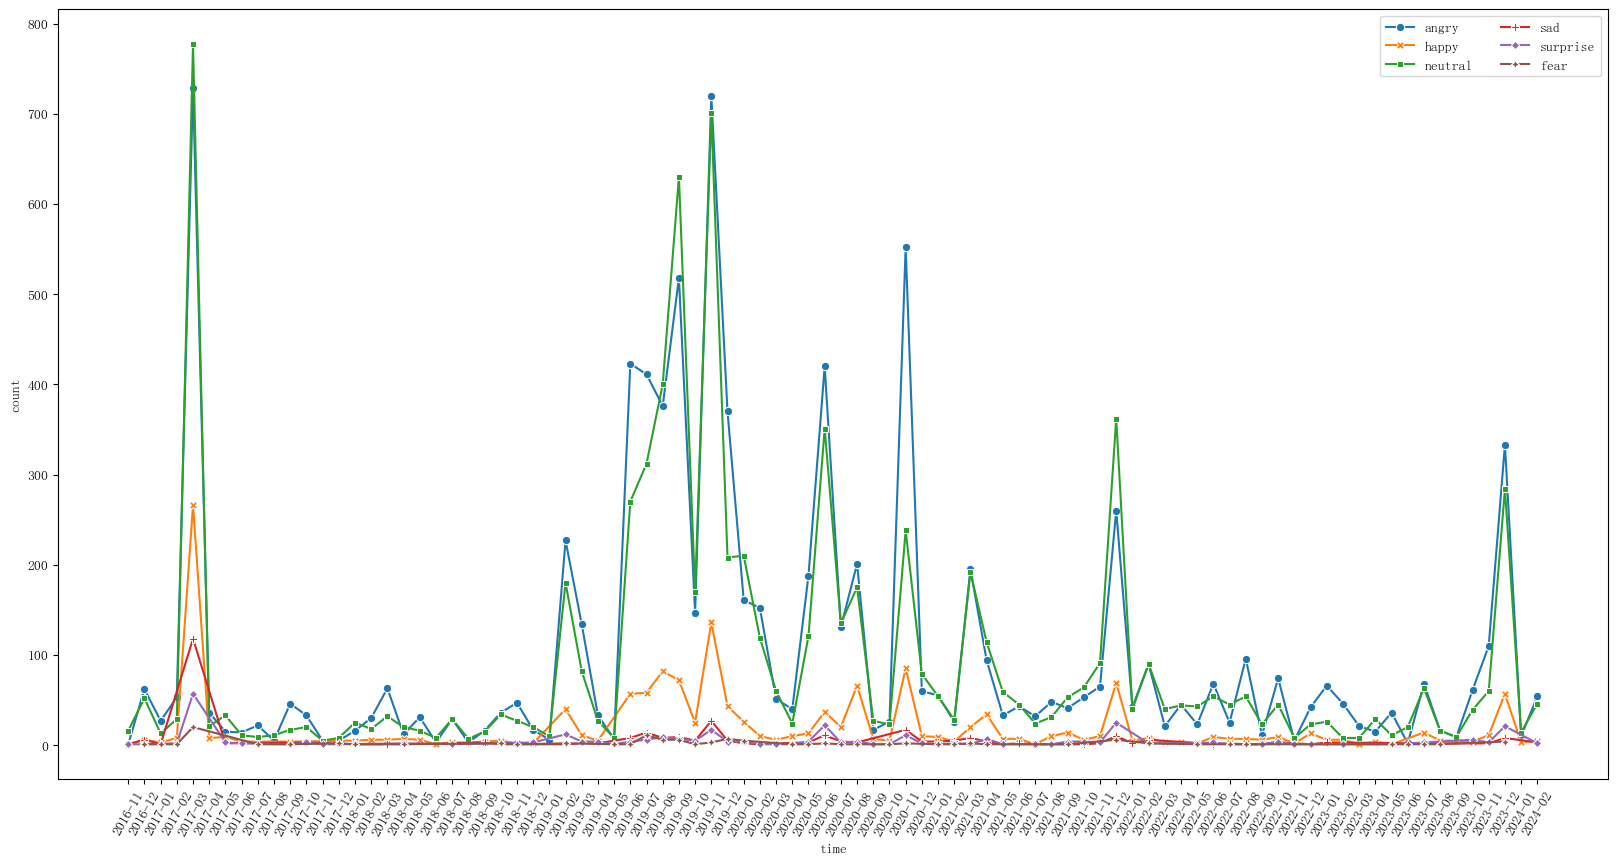

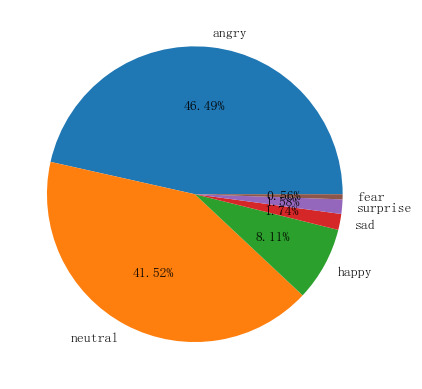

In [32]:
#===Read the data that has been predicted
data = pd.read_csv('Democracy and Justice.csvemotion.csv') 
#similarily, change the file name and repeat for the other two themes

#Set time
data['time'] = pd.to_datetime(data.apply(lambda x:f"{x['year']}-{x['month']}",axis=1)).astype(str).map(lambda x:x[:7])

#Calculate the number of each type of emotion for each month of the year
time_emotion = data.groupby(['time',"Bert's Six Categories-Emotional Tendency"])['text'].agg([('count','count')]).reset_index()

#----Plot graph
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=time_emotion,x='time',y='count',hue="Bert's Six Categories-Emotional Tendency",style="Bert's Six Categories-Emotional Tendency",markers=True,dashes=False,
             linewidth=1.5,markersize='6',ax=ax)
plt.legend(loc=1,ncol=2)
plt.xticks(rotation=60)
plt.savefig('EmotionalChange_DJ.png',dpi = 600,bbox_inches = 'tight') #change name 
plt.show()

#===Pie chart
senti_ = data["Bert's Six Categories-Emotional Tendency"].value_counts()
plt.pie(senti_.values,labels=senti_.index,autopct='%1.2f%%')
plt.savefig('EmotionalTendency_DJ.png',dpi = 600,bbox_inches = 'tight') #change name 
plt.show()  


### Word segmentation and word cloud

For experiment only, not used in final report

In [ ]:
# #============分词词频词云=====
# jieba.set_dictionary('繁体基本词典.txt')

# #分词预处理函数
# def get_cut_content(x):
#     x = re.sub("[^ ^a-z^A-Z^0-9^\u4e00-\u9fa5^,.?!，。？！、]",' ', x) #只保留中英文数字
#     x = x.lower()
#     words = jieba.cut(x, cut_all=False, HMM=True) #分词
#     final = [word for word in words if word not in stopwords and word.isdigit()==False and len(word)>1] #去除停用词和删除字
#     return final
# #停用词
# hit_stopwords = [line.strip().lower() for line in open('hit_stopwords.txt', encoding='utf-8')] #哈工大停用词
# baidu_stopwords = [line.strip().lower() for line in open('baidu_stopwords.txt', encoding='utf-8')] #哈工大停用词
# cn_stopwords = [line.strip().lower() for line in open('cn_stopwords.txt', encoding='utf-8')] #哈工大停用词
# scu_stopwords = [line.strip().lower() for line in open('scu_stopwords.txt', encoding='utf-8')] #哈工大停用词
# stopwords = hit_stopwords+baidu_stopwords+cn_stopwords+scu_stopwords+[' ','','\n','\t','\xa0','\u3000','�','\u200b','\ufeff']#最终停用词
# stopwords = set(stopwords)#自定义的新语料库
# #自定义的新语料库
# jieba.load_userdict('myword.txt')

# #进行分词
# text = data['text'].fillna('').astype(str)
# text_cut = text.map(lambda x:get_cut_content(x))

# #===绘制各类的词云，输出词频结果
# for class_ in data["Bert's Six Categories-Emotional Tendency"].unique():
#     all_words = list(itertools.chain(*text_cut.loc[data["Bert's Six Categories-Emotional Tendency"]==class_])) #全部的单词
#     word_counts = collections.Counter(all_words)  #做词频统计
#     word_counts_top = word_counts.most_common()# 获取前N最高频的词####-------------重要的
#     word_counts_top = pd.DataFrame(word_counts_top,columns=['word','count'])
#     word_counts_top.to_excel(class_+'词频统计结果.xlsx',index=0) #保存词频统计结果
#     wc = WordCloud(width=800, height=600,
#             background_color='white',
#             mode='RGB', 
#             max_words=500,
#             font_path='C:\Windows\Fonts\STZHONGS.ttf',
#             max_font_size=150,
#             relative_scaling=0.5, #设置字体大小与词频的关联程度为0.6
#             random_state=50, 
#             scale=2 ,
#             colormap=sns.color_palette("husl", 10,as_cmap=True)
#             ).fit_words(word_counts)
    
    
#     f, ax = plt.subplots(figsize=(10,9))  #画布大小
#     plt.imshow(wc,interpolation="bilinear") #显示词云
#     plt.axis('off') #关闭x,y轴
#     plt.show()#显示
#     wc.to_file(class_+'词云图.jpg') #保存词云图